## Credits: 
A: Jared

B: Jared

C: Jared

D: Almost all John, Jared calculated means and confidence intervals

E: Almost all Maria, John made the plot at the very end.

## Problem 5.1: Hacker stats and Darwin's finches (100 pts)

Peter and Rosemary Grant of Princeton University have visited the island of Daphne Major on the Galápagos every year for over forty years and have been taking a careful inventory of the finches there. The Grants recently published a wonderful book,  [40 years of evolution: Darwin's finches on Daphne Major Island](http://www.worldcat.org/oclc/854285415). They were generous and made their data publicly available on the [Dryad data repository](http://dx.doi.org/10.5061/dryad.g6g3h). (In general, it is a very good idea to put your published data in public data repositories, both to preserve the data and also to make your findings public.) We will be using this data set to learn about evolution of Darwin's finches and use your hacker statistics skills. Up until part (f), all of your analyses will use nonparametric frequentist hacker stats.

We will focus on the primary two species of ground finch on Daphne Major, *Geospiza fortis* and *Geospiza scandens*. In this [data set](../data/finch_beaks.csv), you will find measurements of the beak length (tip to base) and beak depth (top to bottom) of these finches in the years 1973, 1975, 1987, 1991, and 2012. Also included in that data set is the band number for the bird, which gives a unique identifier.

**a)** We start with a little tidying of the data. Think about how you will deal with duplicate measurements of the same bird and make a decision on how those data are to be treated.



In [1]:
import glob
import os
import sys

import numpy as np
import pandas as pd
import scipy.signal
import numba


# Import Altair for high level plotting
import altair as alt
import altair_catplot as altcat

# Pevent bulky altair plots
alt.data_transformers.enable('json')

import bebi103
import bokeh
import bokeh.plotting
import bokeh.io
from bokeh.palettes import all_palettes 
import itertools
from bokeh.models import Legend, LegendItem
bokeh.io.output_notebook()

Loading BokehJS ...

In [2]:
# Load the data into DataFrame df
df = pd.read_csv('../data/finch_beaks.csv', comment = "#")

In [3]:
# Take a look
df.head()

,band,species,beak length (mm),beak depth (mm),year
0,20123,fortis,9.25,8.05,1973
1,20126,fortis,11.35,10.45,1973
2,20128,fortis,10.15,9.55,1973
3,20129,fortis,9.95,8.75,1973
4,20133,fortis,11.55,10.15,1973


In [4]:
# How long is it?
len(df)

2304

We now need to go through the dataframe and look for duplicates. We will begin by looking for duplicated rows: if we took the same exact measurement twice, down to the year and measurements, we can throw out all but the first one.

In [5]:
# Check for duplicates
df["Duplicates"] = df.duplicated()
df[df["Duplicates"]]

,band,species,beak length (mm),beak depth (mm),year,Duplicates
305,818,fortis,10.2,9.0,1975,True
364,944,fortis,10.3,8.3,1975,True
366,945,fortis,11.6,10.8,1975,True


There are only three, we can remove those easily.

In [6]:
df = df[df["Duplicates"] == False]
df = df.reset_index()
df = df.drop(columns = ["index"])
df.head()

,band,species,beak length (mm),beak depth (mm),year,Duplicates
0,20123,fortis,9.25,8.05,1973,False
1,20126,fortis,11.35,10.45,1973,False
2,20128,fortis,10.15,9.55,1973,False
3,20129,fortis,9.95,8.75,1973,False
4,20133,fortis,11.55,10.15,1973,False


If we measure birds more than once in different years, that information is important, but we don't need to worry about how to deal with that data. The only remaining issue is if we measure the bird more than once in the same year and we take different measurements. Let's check for that:

In [7]:
# Check for duplicates
df["Duplicates"] = df.duplicated(subset = ["band", "year"], keep = False)
df[df["Duplicates"]]

,band,species,beak length (mm),beak depth (mm),year,Duplicates
102,316,fortis,10.9,9.70,1975,True
103,316,fortis,10.9,9.85,1975,True
2054,19028,fortis,12.5,8.90,2012,True
2175,19028,scandens,12.5,8.90,2012,True


This only happened twice. The first one (102 and 103) has two different beak depths by .15 mm. This is probably fine, we can just average the two. The second one has two different species. This is bad, and since we don't know which one is real we should just drop this bird from our dataset. Let's do that now

In [8]:
df = df.drop(df.index[[103, 2054, 2175]])
df.at[102, "beak depth (mm)"] = 9.77
df = df.reset_index()
df = df.drop(columns = ["index", "Duplicates"])
df.head()

,band,species,beak length (mm),beak depth (mm),year
0,20123,fortis,9.25,8.05,1973
1,20126,fortis,11.35,10.45,1973
2,20128,fortis,10.15,9.55,1973
3,20129,fortis,9.95,8.75,1973
4,20133,fortis,11.55,10.15,1973


In [9]:
df_tidy = df[['band',
              'year',
              'species',
              'beak length (mm)', 
              'beak depth (mm)']]
df_tidy.head()

,band,year,species,beak length (mm),beak depth (mm)
0,20123,1973,fortis,9.25,8.05
1,20126,1973,fortis,11.35,10.45
2,20128,1973,fortis,10.15,9.55
3,20129,1973,fortis,9.95,8.75
4,20133,1973,fortis,11.55,10.15


**b)** Plot ECDFs of the beak depths of *Geospiza scandens* in 1975 and in 2012. Then, estimate the mean beak depth for each of these years with confidence intervals.


In [10]:
scandens = df_tidy["species"] == 'scandens'
yr1975 = df_tidy["year"] == 1975
yr2012 = df_tidy["year"] == 2012
df_depths = df_tidy[scandens & (yr1975 | yr2012)].copy()
df_depths.head()

,band,year,species,beak length (mm),beak depth (mm)
401,302,1975,scandens,13.9,8.4
402,304,1975,scandens,14.0,8.8
403,306,1975,scandens,12.9,8.4
404,310,1975,scandens,13.5,8.0
405,317,1975,scandens,12.9,7.9


In [11]:
df_depths.loc[404]["year"]

1975

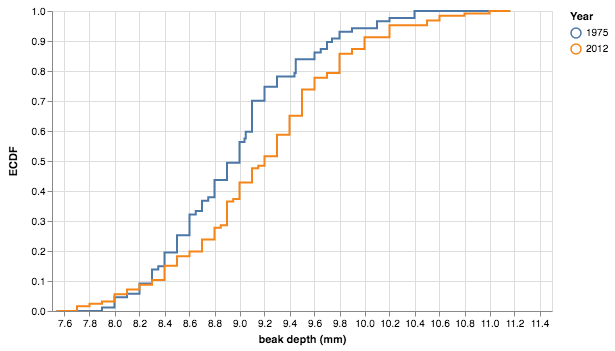

In [12]:
altcat.catplot(data=df_depths,
               height=300,
               width = 500,
               mark='line',
               encoding=dict(x=alt.X('beak depth (mm):Q', 
                                      axis = alt.Axis(title='beak depth (mm)')),
                             color=alt.Color('year:N', title='Year')),
               transform='ecdf')

To estimate the mean we can simply use the numpy mean function:

In [13]:
# Make our datasets
d1975 = df_depths.loc[df_depths["year"] == 1975,
                      "beak depth (mm)"].values
d2012 = df_depths.loc[df_depths["year"] == 2012,
                      "beak depth (mm)"].values

mean_1975 = np.mean(d1975)
mean_2012 = np.mean(d2012)
print("The mean beak depth in 1975 is %.2f mm." 
      % mean_1975)
print("The mean beak depth in 2012 is %.2f mm." 
      % mean_2012)

The mean beak depth in 1975 is 8.96 mm.
The mean beak depth in 2012 is 9.19 mm.


To estimate the confidence intervals, we will draw bootstrap replicates of the mean from the dataset. We will use functions using numba to do this.

In [14]:
@numba.jit(nopython=True)
def draw_bs_sample(data):
    """
    Draw a bootstrap sample from a 1D data set.
    """
    return np.random.choice(data, size=len(data))

@numba.jit(nopython=True)
def draw_bs_reps_mean(data, size=1):
    """
    Draw boostrap replicates of the mean from 1D data set.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = np.mean(draw_bs_sample(data))
    return out

Now lets perform this on the datasets of beak depth for each year:

In [15]:
# Do our bootstrapping
bs_mean_1975_depths = draw_bs_reps_mean(d1975, size=10000)
bs_mean_2012_depths = draw_bs_reps_mean(d2012, size=10000)

Now let's compute the confidence intervals:

In [16]:
# 95% confidence intervals
mean_1975_conf_int = np.percentile(bs_mean_1975_depths, [2.5, 97.5])
mean_2012_conf_int = np.percentile(bs_mean_2012_depths, [2.5, 97.5])

print("""
Mean beak depth 95% conf int 1975 (mm):   [{0:.2f}, {1:.2f}]
Mean beak depth 95% conf int 2012 (mm): [{2:.2f}, {3:.2f}]
""".format(*(tuple(mean_1975_conf_int) + tuple(mean_2012_conf_int))))


Mean beak depth 95% conf int 1975 (mm):   [8.84, 9.08]
Mean beak depth 95% conf int 2012 (mm): [9.07, 9.30]



Let's graph these bootstraps because we can:

In [17]:
p = bebi103.viz.ecdf(bs_mean_1975_depths,
                     x_axis_label='Beak Depth (mm)',
                     color='#4e79a7',
                     legend='1975')
p = bebi103.viz.ecdf(bs_mean_2012_depths, color='#f28e2b', legend='2012', p=p)

p.legend.location = 'bottom_right'

bokeh.io.show(p)

**c)** Perform a hypothesis test comparing the *G. scandens* beak depths in 1975 and 2012. Carefully state your null hypothesis, your test statistic, and your definition of what it means to be at least as extreme as the observed test statistic. Comment on the results. It might be interesting to know that a severe drought in 1976 and 1977  resulted in the death of the plants that produce small seeds on the island.

Our null hypothesis is that the distribution of beak depths in 2012 is the same as the distribution of the beak depths in 1975.

Our test statistic is the difference in the mean of the two distributions.

We will use a permutation test to test this null hypothesis. Thus, we will define that to be at least as extreme as the observed test statistics the difference between the means of the two new data sets in the permutation sample must be greater than or equal to the difference in the mean of the empirical distributions.

To start, we will define some functions to generate permutation samples and to generate an array of permutation replicates using our test statistic as defined above:

In [18]:
@numba.jit(nopython=True)
def draw_perm_sample(x, y):
    """Generate a permutation sample."""
    concat_data = np.concatenate((x, y))
    np.random.shuffle(concat_data)
    return concat_data[:len(x)], concat_data[len(x):]

@numba.jit(nopython=True)
def draw_perm_reps_diff_mean(x, y, size=1):
    """
    Generate array of permuation replicates.
    """
    out = np.empty(size)
    for i in range(size):
        x_perm, y_perm = draw_perm_sample(x, y)
        out[i] = np.mean(x_perm) - np.mean(y_perm)
    return out


Now let's compute!

In [19]:
# Compute test statistic for original data set
diff_mean = np.mean(d2012) - np.mean(d1975)

# Draw replicates
perm_reps = draw_perm_reps_diff_mean(d2012, d1975, size=1000000)

# Compute p-value
p_val = np.sum(perm_reps >= diff_mean) / len(perm_reps)

print('p-value =', p_val)

p-value = 0.004863


Our p-value < .005, thus the probability of getting a difference of means as extreme as the observed one under the null hypothesis is small, so we can reject the null hypothesis. This suggests there is a statistically significant difference in the beak depths of finches between 1975 and 2012, suggesting that the size of the finch beaks changed. From part B we can see that the observed change in size was an increase. In light of the drought in 1976 and 1977 resulted in the death of the plants that produce small seeds on the island, we can hypothesize that the finches have evolved deeper beaks allowing them to eat larger seeds more easily in this time period, due to the selective pressure to be better able to eat larger seeds due to the lack of small seeds.


**d)** Devise a measure for the *shape* of a beak. That is, invent some scalar measure that combines both the length and depth of the beak. Compare this measure between species and through time. (This is very open-ended. It is up to you to define the measure, make relevant plots, compute confidence intervals, and possibly do hypothesis tests to see how shape changes over time and between the two species.)

I think that an interesting measure of beak shape would be constant for any given organism over time, but perhaps would be variable for a population or across species. To this end, I want to look at the relationship between the two measurements on the same bird over time, and see if beak growth (or decay) is common among each bird. 

In [20]:
bird_ids = np.unique(df_tidy["band"].values)
print("There are %i different birds in the study." %len(bird_ids))

# Array of the form (lifespan, num_measurements)
lifespans = np.zeros([len(bird_ids), 2])

for i, id_num in zip(range(0, len(bird_ids)), bird_ids):
    df_single_bird = df_tidy[df_tidy["band"] == id_num]
    arr_single_bird = df_single_bird["year"].values
    lifespans[i][0] = np.max(arr_single_bird) - np.min(arr_single_bird)
    lifespans[i][1] = len(arr_single_bird)
print("Average bird lifespan: %.2f           Standard Dev: %.2f" 
      % (np.average(lifespans[...,0]), np.std(lifespans[...,0])))
print("Average number of measurements: %.2f  Standard Dev: %.2f" 
      % (np.average(lifespans[...,1]), np.std(lifespans[...,1])))

There are 1953 different birds in the study.
Average bird lifespan: 0.71           Standard Dev: 1.56
Average number of measurements: 1.18  Standard Dev: 0.38


It seems like most of our birds did not survive to the second measurement, but finches should live longer than a year. What happened?

In [21]:
bird_years = np.unique(df_tidy["year"].values)
print("Years we have measurements for: %i" %len(bird_years))
print("Duration of experiment: %i" %(2012 - 1973 + 1))

Years we have measurements for: 5
Duration of experiment: 40


At best, we only have measurements that were taken every 8 years. This will make developing a shape independent of the growth of individual finches very difficult, given that we are unlikely to have more than 2 datapoints for any finch. Furthermore, this reveals that our above calculation for the average finch lifespan is roughly nonsense. 

At this point, it seems better to try and find an intuitive measure of beak shape, rather than struggle against limited data to find a more complex model. We will take a simple ratio, because we would like the shape to be independent of size. We expect that beak depth will have slightly less variability, so this shall be the denominator. Thus:
$$\text{Shape } = s = \frac{\text{beak length}}{\text{beak depth}}$$
I will add this parameter to the dataframe. 

In [22]:
df_tidy.loc[:,"Shape"] = (df_tidy.loc[:,"beak length (mm)"] / df_tidy.loc[:,"beak depth (mm)"])
df_tidy.head()

/Users/john/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/john/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,band,year,species,beak length (mm),beak depth (mm),Shape
0,20123,1973,fortis,9.25,8.05,1.149068
1,20126,1973,fortis,11.35,10.45,1.086124
2,20128,1973,fortis,10.15,9.55,1.062827
3,20129,1973,fortis,9.95,8.75,1.137143
4,20133,1973,fortis,11.55,10.15,1.137931


Now I will make a plot that displays the distribution of beak shape across species and time. 

In [23]:
bird_species = np.unique(df_tidy["species"].values)
# Deals with coloring of different lines
colors = all_palettes['Viridis'][10]

first = True # used to only show the first plot. 

p = bokeh.plotting.Figure(width = 800, 
                          height = 500,
                          title = "Beak shape across time and species",
                          x_axis_label = "Beak Shape")

plots = [0] * len(bird_years)

for year, index in zip(bird_years, range(0, len(bird_years))):
    
    name = str(year)
    
    df_temp = df_tidy[df_tidy["year"] == year]
    df_temp_1 = df_temp[df_temp["species"] == bird_species[0]]
    df_temp_2 = df_temp[df_temp["species"] == bird_species[1]]
    p = bebi103.viz.ecdf(df_temp_1["Shape"].values, p=p, 
                         color=colors[index], visible = first, 
                         legend = name +" "+ bird_species[0])
    p = bebi103.viz.ecdf(df_temp_2["Shape"].values, p=p, 
                         color=colors[index + 5], visible = first, 
                         legend = name +" "+ bird_species[1])
    
    p.legend.click_policy = 'hide'
    p.legend.location = "bottom_right"
    first = False # used to only show the first plot. 

bokeh.io.show(p)

We will compute the mean beak shape for every year and species. Since we are working on a larger number of datasets than in part b, let's define a function that can take as its arguments the dataframe, the year, and the species and return a print statement describing the mean beak length for that slice. We can also include the confidence interval using our bootstrapping methods

In [24]:
def mean_beak_shape(df, year, species):
    """Finds the mean beak shape for a given year and species, and
       returns it along with a confidence interval."""
    # Isolate species and year
    df_year = df.loc[df["year"] == year]
    dataset_species = df_year.loc[df_year["species"] == species, 
                                  "Shape"].values
    # Calculate mean
    mean = np.mean(dataset_species)
    
    # Calculate 95% confidence interval for mean. 
    bs_mean_shape = draw_bs_reps_mean(dataset_species, size=10000)
    mean_shape_conf_int = np.percentile(bs_mean_shape, [2.5, 97.5])
    return (mean, mean_shape_conf_int)

def print_beak_shape(species, year, mean, mean_shape_conf_int):
    """Helper function to report beak shapes."""
    print("The mean beak shape for {0:.8s} in {1:.0f} is {2:.2f},".format(*(species, year, mean)))
    print("with a 95% confidence interval of: [{0:.2f}, {1:.2f}]".format(*(tuple(mean_shape_conf_int))))

Now let's execute that on our dataset to see the mean beak shape for each species in each year:

In [25]:
names = ["fortis", "scandens"]
years = [1973, 1975, 1987, 1991, 2012]

for species in names:
    for year in years:
        (mean, mean_shape_conf_int) = mean_beak_shape(df_tidy, year, species)
        print_beak_shape(species, year, mean, mean_shape_conf_int)
        

The mean beak shape for fortis in 1973 is 1.12,
with a 95% confidence interval of: [1.10, 1.13]
The mean beak shape for fortis in 1975 is 1.15,
with a 95% confidence interval of: [1.15, 1.16]
The mean beak shape for fortis in 1987 is 1.18,
with a 95% confidence interval of: [1.17, 1.18]
The mean beak shape for fortis in 1991 is 1.18,
with a 95% confidence interval of: [1.17, 1.18]
The mean beak shape for fortis in 2012 is 1.22,
with a 95% confidence interval of: [1.21, 1.24]
The mean beak shape for scandens in 1973 is 1.55,
with a 95% confidence interval of: [1.49, 1.61]
The mean beak shape for scandens in 1975 is 1.58,
with a 95% confidence interval of: [1.56, 1.60]
The mean beak shape for scandens in 1987 is 1.56,
with a 95% confidence interval of: [1.54, 1.57]
The mean beak shape for scandens in 1991 is 1.54,
with a 95% confidence interval of: [1.52, 1.55]
The mean beak shape for scandens in 2012 is 1.47,
with a 95% confidence interval of: [1.45, 1.48]


Let's display this graphically, because why not?

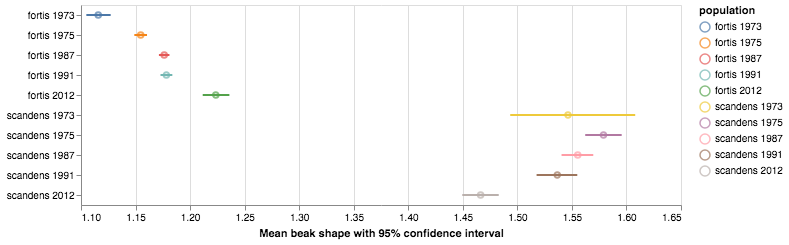

In [26]:
chart = None
for species in names:
    for year in years:
        # Actually calculate statistics
        (mean, mean_shape_conf_int) = mean_beak_shape(df_tidy, year, species)
        name = species + " " + str(year)
        
        # Plotting confidence intervals and points at once is tricky, 
        # so I chose to make several dataframes and several altair 
        # plots, and then overlay them one by one.
        
        # Plot confidence intervals!
        df = pd.DataFrame(data = {"population": [name] * 2, 
                                  "conf_int": mean_shape_conf_int})
        
        ch = alt.Chart(df, height=200, width=600).mark_line(
                         ).encode(x = alt.X("conf_int:Q", 
                                            scale=alt.Scale(zero=False)), 
                                  y = "population:N",
                                  color = alt.Color("population:N"))
        # This takes care of the first chart overlay
        if type(chart) == type(None):
            chart = ch
        else:
            chart = chart + ch
        
        # Plot means!
        df = pd.DataFrame(data = {"population": [name],
                                  "mean": [mean]})
        ch = alt.Chart(df, height=200, width= 600).mark_point(
                         ).encode(x = alt.X("mean:Q", 
                                            scale=alt.Scale(zero=False),
                                            title = "Mean beak shape with 95% confidence interval"), 
                                  y = alt.Y("population:N", 
                                            title = None),
                                  color = alt.Color("population:N"))
        chart = chart + ch
chart

This looks great! The most apparent observation from both plots we have made so far is that the shape of the beak of birds from each poplulation seems to converge over the 40 years of the experiment. We can perform a hypothesis test with the following parameters:

Null hypothesis:  There was no convergence in beak shape. Specifically, the mean beak shape for both species has been stationary over time. 

Test statistic:  initial mean difference in beak shape minus the final mean difference in beak shape.

I will start by computing the test statistic for our experiment:

In [27]:
(mean_f_73, mean_shape_conf_int) = mean_beak_shape(df_tidy, 1973, "fortis")
(mean_f_12, mean_shape_conf_int) = mean_beak_shape(df_tidy, 2012, "fortis")
(mean_s_73, mean_shape_conf_int) = mean_beak_shape(df_tidy, 1973, "scandens")
(mean_s_12, mean_shape_conf_int) = mean_beak_shape(df_tidy, 2012, "scandens")
convergence = (mean_s_73 - mean_f_73) - (mean_s_12 - mean_f_12)
print("Convergence of beak shape for our experiment: %.3f" % convergence)

Convergence of beak shape for our experiment: 0.188


Now I want to isolate the beak shapes for these years and species so that I can perform permutation replicates. 

In [28]:
df = df_tidy[df_tidy["year"] == 1973]
df = df[df["species"] == "fortis"]
shapes_f_73 = df["Shape"].values

df = df_tidy[df_tidy["year"] == 2012]
df = df[df["species"] == "fortis"]
shapes_f_12 = df["Shape"].values

df = df_tidy[df_tidy["year"] == 1973]
df = df[df["species"] == "scandens"]
shapes_s_73 = df["Shape"].values

df = df_tidy[df_tidy["year"] == 2012]
df = df[df["species"] == "scandens"]
shapes_s_12 = df["Shape"].values

Suppose that there was no real convergence in beak shape. In this case, we would be pulling from the same distribution whenever we measured the shape of a bird's beak, regardless of which year it was. This is how I will model the permutation replicates. 

In [29]:
@numba.jit(nopython=True)
def draw_perm_reps_diff_diff_mean(x1, x2, y1, y2, size=1):
    out = np.empty(size)
    for i in range(0, size):
        # s = species, t = time
        # Here I draw two randomized samples from the pool of 1793 
        # and 2012 beak shapes for each species. 
        sample_s1_t1, sample_s1_t2 = draw_perm_sample(x1, x2)
        sample_s2_t1, sample_s2_t2 = draw_perm_sample(y1, y2)
        out[i] = ((np.mean(sample_s1_t1) - np.mean(sample_s2_t1))
                   - (np.mean(sample_s1_t2) - np.mean(sample_s2_t2)))
    return out

In [30]:
reps = draw_perm_reps_diff_diff_mean(shapes_s_73,
                                     shapes_s_12,
                                     shapes_f_73,
                                     shapes_f_12,
                                     size = 10000000)
count = 0
for rep in reps:
    if rep > convergence:
        count += 1
print("p-value: %.8f" %(count / len(reps)))

p-value: 0.00000000


The p-value seems to be so low that it is impossible to calculate in a reasonable amount of time. Thus, the null hypothesis is clearly wrong, and we have validated our suspicion that beak shapes have converged over the duration of the experiment. 

**e)** Introgressive hybridization occurs when a *G. scandens* bird mates with a *G. fortis* bird, and then the offspring mates again with pure *G. scandens*. This brings traits from *G. fortis* into the *G. scandens* genome. As this may be a mode by which beak geometries of *G. scandens* change over time, it is useful to know how *heritable* a trait is. Heritability is defined as the ratio of the covariance between parents and offsprings to the *variance of the parents alone*. To be clear, the heritability is defined as follows.

1. Compute the average value of a trait in a pair of parents.
2. Compute the average value of that trait among the offspring of those parents.
3. Do this for each set of parents/offspring. Using this data set, compute the covariance between the average offspring and average parents and the variance among all average parents.
4. The heritability , $h^2$, is the ratio of the covariance between parents and offspring to the variance of the parents, $h^2 = \sigma_{po}/\sigma_p^2$.

This is a more apt definition than, say, the Pearson correlation, because it is a direct comparison between parents and offspring. 

Heritability data for beak depth for *G. fortis* and *G. scandens* can be found [here](../data/fortis_beak_depth_heredity.csv) and [here](../data/scandens_beak_depth_heredity.csv), respectively. (Be sure to look at the files before reading them in; they do have different formats.) From these data, compute the heritability of beak depth in the two species, with confidence intervals. How do they differ, and what consequences might this have for introgressive hybridization?

We first look at the species scandens.

We load in the data and look at it. We are given some useful information about the columns:

- mid_parent is the average beak depth of a male and female pair in millimeters.

- mid_offspring is the average beak depth of their offspring in millimeters.

In [31]:
# Load the data into DataFrame df
df_scand = pd.read_csv('../data/scandens_beak_depth_heredity.csv', comment = "#")

df_scand.head()

,mid_parent,mid_offspring
0,8.3318,8.4190
1,8.4035,9.2468
2,8.5317,8.1532
3,8.7202,8.0089
4,8.7089,8.2215


We now calculate the covariance between the averahe offspring and average parents.

In [32]:
cov_scand = np.cov(df_scand["mid_parent"], df_scand["mid_offspring"])
print("The covariance between the average offspring and average parents is {}".format(cov_scand[0][1]))

The covariance between the average offspring and average parents is 0.05696765903577816


We calculate the variance between the average parents.

In [33]:
var_scand = np.var(df_scand["mid_parent"])
print("The variance among all average parents is {}".format(var_scand))

The variance among all average parents is 0.10305548484082841


We divide the two to get the heritability.

In [34]:
heritability_scand = cov_scand[0][1] / var_scand
print("Finally, we conclude that the heritability of scandens is {}".format(heritability_scand))

Finally, we conclude that the heritability of scandens is 0.5527862890923858


Now, we want to compute the confidence interval of the data. We write functions to bootstrap samples. Then, we calculate the heritability of each sample and store it in an np array bs_her_scand.

In [35]:
def draw_bs_sample(data):
    """
    Draw a bootstrap sample from a 1D data set.
    """
    return np.random.choice(data, size=len(data))

def draw_bs_reps_her(parent_array, off_array, size=1):
    """
    Draw boostrap replicates of the mean from 1D data set.
    """
    out = np.empty(size)
    for i in range(size):
        index = draw_bs_sample(np.arange(len(parent_array)))
        parent = parent_array[index]
        off = off_array[index]
        cov = np.cov(parent, off)[0][1]
        var = np.var(parent)
        her = cov / var
        out[i] = her
    return out

In [36]:
bs_her_scand = draw_bs_reps_her(df_scand["mid_parent"].values, df_scand["mid_offspring"].values, size=20000)

Now, we can actually compute the 95% confidence intervals.

In [37]:
# 95% confidence intervals
scand_her_conf_int = np.percentile(bs_her_scand, [2.5, 97.5])
scand_her_conf_int

array([0.35183195, 0.75573296])

We now consider the species fortis.

We load in the data and look at it. We are given some useful information about the columns:
- Mid-offspr represents the average beak depth in millimeters of the offspring of two parents.
- Male BD and Female BD represent the parental beak depths in millimeters.

In [38]:
df_fort = pd.read_csv('../data/fortis_beak_depth_heredity.csv', comment = '#')
df_fort.head()

,Mid-offspr,Male BD,Female BD
0,10.70,10.90,9.3
1,9.78,10.70,8.4
2,9.48,10.70,8.1
3,9.60,10.70,9.8
4,10.27,9.85,10.4


The first step to computing heritability is to compute the average value of that trait among the offspring of those parents, so we store that value in Mid-parent.

In [39]:
# compute average value of trait for two parents
df_fort["Mid-parent"] = (df_fort["Male BD"] + df_fort["Female BD"]) / 2
df_fort.head()

,Mid-offspr,Male BD,Female BD,Mid-parent
0,10.70,10.90,9.3,10.100
1,9.78,10.70,8.4,9.550
2,9.48,10.70,8.1,9.400
3,9.60,10.70,9.8,10.250
4,10.27,9.85,10.4,10.125


Now we will compute the covariance between the average offspring and average parents and the variance among all average parents as we've already done above for the other species.

In [40]:
cov_fort = np.cov(df_fort["Mid-offspr"], df_fort["Mid-parent"])
print("The covariance between the average offspring and average parents is {}".format(cov_fort[0][1]))

var_fort = np.var(df_fort["Mid-parent"])
print("The variance among all average parents is {}".format(var_fort))

heritability_fort = cov_fort[0][1] / var_fort
print("Finally, we conclude that the heritability of fortis is {}".format(heritability_fort))

The covariance between the average offspring and average parents is 0.345044283187193
The variance among all average parents is 0.47614656678528955
Finally, we conclude that the heritability of fortis is 0.7246598153941641


We repeat the same process as we went through for Scand to find the confidence interval of Fortis. We first bootstrap using our predefined functions.

In [41]:
bs_her_fort = draw_bs_reps_her(df_fort["Mid-parent"].values, df_fort["Mid-offspr"].values, size=20000)

And then we can calculate the confidence interval.

In [42]:
# 95% confidence intervals
fort_her_conf_int = np.percentile(bs_her_fort, [2.5, 97.5])
fort_her_conf_int

array([0.64744572, 0.79861648])

We now look at how they differ, and what consequences might this have for introgressive hybridization.

Scandens 95% confidence interval: **[0.3524225 , 0.75885995]**

Fortis 95% confidence interval: **[0.64786953, 0.80049313]**

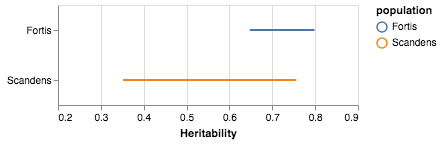

In [43]:
# Make dataframes for each necessary line
df = pd.DataFrame(data = {"population": ["Fortis"] * 2, 
                          "conf_int": fort_her_conf_int})
df2 = pd.DataFrame(data = {"population": ["Scandens"] * 2, 
                          "conf_int": scand_her_conf_int})

# Plot confidence intervals!
def get_chart(df):
    ch = alt.Chart(df, height=100, width=300).mark_line(
                     ).encode(x = alt.X("conf_int:Q", 
                                        scale=alt.Scale(domain = [0.2,0.9]),
                                        title = "Heritability"), 
                              y = alt.Y("population:N", title = None),
                              color = alt.Color("population:N"))
    return ch
get_chart(df) + get_chart(df2)

We observe that the Fortis heritability is significantly higher and has a much narrower range of potential values. This means that as introgressive hybridization occurs, the beak geometries of G. scandens will start to resemble Fortis beak geometries much more closely.